# Лабораторная работа 2. Решающие деревья и случайные леса.

ФИО: Думбай Алексей Дмитриевич

Группа: 317

In [1]:
import numpy as np

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

### I. Решающие деревья своими руками
#### Задача 1.
В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__1__

Реализуйте следующую функцию:

In [4]:
def find_best_split(feature_vector, target_vector):
    answer = target_vector[np.argsort(feature_vector)]
    feature = np.sort(feature_vector)
    pos_num = np.cumsum(answer)
    pos = np.sum(answer)
    size = feature.shape[0]
    nums = np.arange(1,size + 1)
    pos_freq = pos_num / nums
    inv_freq = (pos - pos_num) / (size - nums)
    ginis = nums * (1 - (pos_freq ** 2 + (1 - pos_freq)  ** 2)) +\
            (size - nums) * (1 - (inv_freq ** 2 + (1 - inv_freq)  ** 2))
    ginis = - ginis / size
    indices = [feature[:-1] != feature[1:]]
    thresholds = feature[:-1][indices]
    if thresholds.shape[0] == 0:
        return
    ginis = ginis[:-1][indices]
    opt_threshold = thresholds[np.argmax(ginis)]
    opt_giny = np.max(ginis)
    return thresholds, ginis, opt_threshold, opt_giny

Параметры:
* feature_vector: вещественнозначный вектор значений признака (np.array)
* target_vector: вектор классов объектов (np.array). len(feature_vector)==len(target_vector).

Возвращаемые значения:
* thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно разделить на две различные подвыборки, или поддерева (np.array)
* ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds. (np.array, len(ginis)==len(thresholds))
* оптимальный порог (число)
* оптимальное значение критерия Джини (число)

Под критерием Джини здесь подразумевается следующая функция:
$$Q(R) = -\frac {|R_l|}{|R|}H(R_l) -\frac {|R_r|}{|R|}H(R_r),$$
$R$ - множество объектов, $R_l$ и $R_r$ - объекты, попавшие в левое и правое поддерево, $H(R) = 1-p_1^2-p_0^2$, $p_1$, $p_0$ - доля объектов класса 1 и 0 соответственно.

Указания:
* Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
* За наличие в функции циклов балл будет снижен. Векторизуйте! :)

__2__
Загрузите таблицу [students.csv](https://drive.google.com/file/d/0B2zoFVYw1rN3a0d0Zm43TzQ4aUU/view?usp=sharing) (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах,а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог - значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака - класс" для всех пяти признаков.

In [5]:
students = pd.read_csv("students.csv")

In [6]:
students.columns

Index(['STG', 'SCG', 'STR', 'LPR', 'PEG', ' UNS'], dtype='object')

In [7]:
STG = np.array(students["STG"])
SCG = np.array(students["SCG"])
STR = np.array(students["STR"])
PEG = np.array(students["PEG"])
LPR = np.array(students["LPR"])
y = np.array(students[" UNS"])

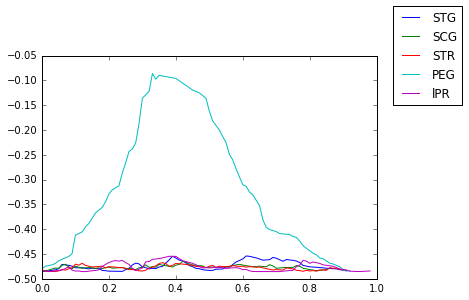

In [8]:
thresholds, ginis, none, none = find_best_split(STG, y)
plt.plot(thresholds, ginis, label='STG')
thresholds, ginis, none, none = find_best_split(SCG, y)
plt.plot(thresholds, ginis, label='SCG')
thresholds, ginis, none, none = find_best_split(STR, y)
plt.plot(thresholds, ginis, label='STR')
thresholds, ginis, none, none = find_best_split(PEG, y)
plt.plot(thresholds, ginis, label='PEG')
thresholds, ginis, none, none = find_best_split(LPR, y)
plt.plot(thresholds, ginis, label='lPR')

plt.legend(bbox_to_anchor=(1.05, 1), loc=6, borderaxespad=0.)

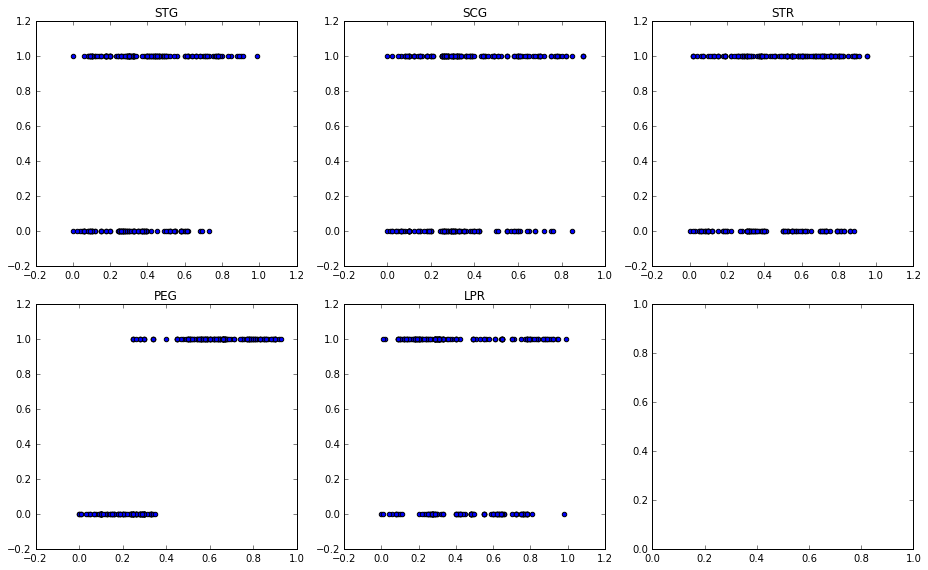

In [9]:
fig, ((ax1, ax2, ax3), (ax4, ax5, none)) = plt.subplots(2, 3, figsize=(13, 8))

ax1.scatter(STG, y, label='STG')
ax1.set_title('STG')
ax2.scatter(SCG, y, label='SCG')
ax2.set_title('SCG')
ax3.scatter(STR, y, label='STR')
ax3.set_title('STR')
ax4.scatter(PEG, y, label='PEG')
ax4.set_title('PEG')
ax5.scatter(LPR, y, label='LPR')
ax5.set_title('LPR')
    
fig.tight_layout()

__3__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

Согласно виду кривых деление выборки следует проводить по признаку "PEG", что согласуется со scatter-графиками. 
Вид кривой для хороших признаков выглядит примерно как возрастающая в начале, достигающая максимума и после этого убывающая. Это объясняется тем, что для "хороших" признаков у нас до како-го то порога идут почти все значения с одним классом, после - почти все с другим. И в среднем каждый шаг до этой позиции увеличивает значение критерия Джини. после - уменьшает.
Для плохих признаков график похож на горизонтальную прямую с небольшими колебаниями. Это обусловлено смешиванием объектов с Близкими значениями признака, но разными классамию

__4__

Реализуйте класс для обучения решающих деревьев. Мы не будем усложнять класс множеством параметров, как в sklearn. Требования к классу:
* Единственный параметр дерева - вектор, задающий типы признаков: если в позиции i стоит 0, то с признаком номер i нужно работать как с вещественным, если 1 - как с категориальным.
* Чтобы классификатор "распознавался" функциями sklearn, необходимо наследовать его от BaseEstimator. 
* У класса должно быть реализовано два метода: fit и predict. Метод fit принимает на вход двумерный np.array - матрицу объекты-признаки и одномерный вектор ответов y, внутри метода происходит обучение дерева. Метод predict принимает на вход двумерную матрицу объекты-признаки (np.array) и возвращает вектор предсказанных классов (одномерный np.array) для всех объектов.
* Построение дерева должно осуществляться согласно базовому жадному алгоритму. Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу. Ответ в листе: класс объектов, находящихся в нем. Для категориальных признаков необходимо выполнить преобразование, описанное на [семинаре](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem04_trees.pdf) в разделе "Учет категориальных признаков".

Далее будут даны рекомендации по реализации решающего дерева. Им следовать необязательно: например, вы можете использовать свою структуру для хранения дерева.
* Дерево можно хранить в виде сложенных списков. Каждая внутренняя вершина дерева - список node длины 4: node[0] хранит индекс признака, по которому в данной вершине делается разбиение, node[1] - порог для разбиения, если i-й признак вещественный, и множество значений признака, с которыми объект попадает в левое поддерево, если i-й признак категориальный, node[2] - левое поддерево (список) и node[3] - правое поддерево (список). В листьях node состоит из единственного элемента - ответа, возвращаемого в этом листе. Пример простого дерева, разделяющего выборку по нулевому признаку по порогу 5 на два листа, возвращающих класс 0 и 1: [0, 5, [0], [1]]. Если в левом поддереве корня выполнять разделение по 1-му признаку по порогу 7: [0, 5, [1, 7, [0], [1]], [1]].
* Внутри функции fit определяется рекурсивная функция fit_node(subX, suby, node), принимающая матрицу объекты-признаки subX и ответы на этих объектах suby, а также ссылку на пустой список node - вершину, в которой необходимо выполнить разбиение на две подвыборки. Функция fit_node должна заполнить этот список вызовами node.append(.....). Если suby состоит из одинаковых значений, нужно добавить к node это значение и выйти. Иначе выполнить перебор по всем признакам: для каждого признака с помощью функции find_best_split найти наилучшее разбиение и выбрать признак, дающий максимальное значение критерия Джини. Для категориальных признаков нужно выполнить специальное преобразование (см. семинар). Вершину нужно заполнить индексом выбранного признака, порогом или множеством значений (задающих разбиение), а затем рекурсивно вызвать fit_node для левого и правого поддерева.
* Внутри функции predict также определяется рекурсивная функция predict_node(x, node), принимающая один объект и вершину. Она проверяет, является ли node листом (это можно определить по длине списка), если да - возвращает node[0], т. е. класс, задаваемый этим листом. Иначе функция определяет, к какому поддереву относится объект, и рекурсивно вызывает себя для этого поддерева.
* В процессе тестирования кода может оказаться, что рекурсивные вызовы повторяются бесконечно. Так происходит, если в одно из поддеревьев попадает пустая подвыборка. Этого быть не должно: пороги, при которых все объекты попадают в одно поддерево, не рассматриваются (см. указания к функции find_best_split).
* Дерево должно давать единичную долю верных ответов на обучающей выборке.
* Протестировать, правильно ли выполняется преобразование категориальных признаков, можно на простой синтетической выборке с одним категориальным признаком, по которому объекты идеально делятся на два класса, и при этом такого эффекта нельзя достичь установкой порога на этот признак.

In [10]:
from sklearn.base import BaseEstimator

In [11]:
### Шаблон класса, следующего рекомендациям
class DecisionTree(BaseEstimator):
    def __init__(self, types):
        self._tree = []
        self.types = types

    def fit(self, X, y):
        def fit_node(subX, suby, node):
            if len(suby)==0:
                return
            if len(np.unique(suby)) == 1:
                node.append(suby[0])
                return
            max_gini = -1.1
            max_feature = -1
            node_data = None
            node_ind = None
            for i in range(subX.shape[1]):
                if self.types[i] == 0:
                    split = find_best_split(subX[:, i], suby)
                    if split is None:
                        continue
                    none, none, thrasehold, gini  = split
                    if gini > max_gini:
                        max_gini = gini
                        max_feature = i
                        node_data = thrasehold
                        node_ind = subX[:, i] <= thrasehold
                else:
                    cnt, rev_ind, nums = np.unique(subX[:, i], return_inverse=True, return_counts=True) 
                    scc = np.zeros(cnt.shape[0])
                    for j, obj in enumerate(cnt):
                        
                        summ = np.sum(suby[subX[:, i] == obj])
                        scc[j] = summ
                    new_feat = (scc / nums)[rev_ind]
                    split = find_best_split(new_feat, suby)
                    if split is None:
                        continue
                    none, none, thrasehold, gini  = split
                    if gini > max_gini:
                        max_gini = gini
                        max_feature = i
                        node_ind = new_feat <= thrasehold
                        node_data = list(set(subX[:, i][node_ind]))
            if max_feature == -1:
                arg, counts = np.unique(suby, return_counts=True)
                node.append(arg[np.argmax(counts)])
                return
            node.extend([max_feature, node_data, [], []])
            fit_node(subX[node_ind, :], suby[node_ind], node[2])
            fit_node(subX[~node_ind, :], suby[~node_ind], node[3])

        self._tree = []
        fit_node(X, y, self._tree)
        
    def predict(self, X):
        def predict_node(x, node):
            if len(node)==1:
                return node[0]
            if self.types[int(node[0])] == 0:
                if x[int(node[0])] <= node[1]:
                    return predict_node(x, node[2])
                else:
                    return predict_node(x, node[3])
            else:
                if x[int(node[0])] in node[1]:
                    return predict_node(x, node[2])
                else:
                    return predict_node(x, node[3])
                    
        predicted = []
        for x in X:
            predicted.append(predict_node(x, self._tree))
        return np.array(predicted)

__5__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец - это целевая переменная (e-edible, p-poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что - классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [12]:
mushrooms = pd.read_table('agaricus-lepiota.data.txt', sep=',', names=['class', 'cap-shape', 
                          'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment',
                          'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root',
                          'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring',
                          'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
                          'ring-type', 'spore-print-color', 'population', 'habitat']) 
mushrooms.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [13]:
encoder = LabelEncoder()

In [14]:
for col in mushrooms.columns:
    if col != "class":
        encoder.fit(mushrooms[col])
        mushrooms[col] = encoder.transform(mushrooms[col])
mushrooms_X = np.array(mushrooms.drop("class", axis=1))
mushrooms_y = mushrooms["class"]
mushrooms_y.replace(["p"], 0, inplace=True)
mushrooms_y.replace(["e"], 1, inplace=True)
mushrooms_y = np.array(mushrooms_y)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(mushrooms_X, mushrooms_y, test_size=0.5)

In [16]:
tree = DecisionTree(np.ones(X_train.shape[1]))
tree.fit(X_train, y_train)
answer = tree.predict(X_test)
print("Accuracy: {}".format(accuracy_score(y_test, answer)))

Accuracy: 0.9992614475627769


__6__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-rac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc - это класс 0, good, vgood - класс 1)
* [nurcery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recom - класс 0, very_recom, priority, spec_prior - класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам - наборы данных, по столбцам - алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scorer=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [17]:
tic_tac_toe = pd.read_table('tic-tac-toe.data.txt', sep=',', names=['top-left-square', 'top-middle-square', 
                            'top-right-square', 'middle-left-square', 'middle-middle-square', 'middle-right-square', 
                            'bottom-left-square', 'bottom-middle-square', 'bottom-right-square', 'class'])

In [18]:
for col in tic_tac_toe.columns:
    if col != "class":
        encoder.fit(tic_tac_toe[col])
        tic_tac_toe[col] = encoder.transform(tic_tac_toe[col])
tic_tac_toe_X = np.array(tic_tac_toe.drop("class", axis=1))
tic_tac_toe_y = tic_tac_toe["class"]
tic_tac_toe_y.replace(["positive"], 1, inplace=True)
tic_tac_toe_y.replace(["negative"], 0, inplace=True)
tic_tac_toe_y = np.array(tic_tac_toe_y)

In [19]:
cars = pd.read_table('car.data.txt', sep=',',
                       names=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class'])

In [20]:
for col in cars.columns:
    if col != "class":
        encoder.fit(cars[col])
        cars[col] = encoder.transform(cars[col])
cars_X = np.array(cars.drop('class', axis=1))
cars_y = cars["class"]
cars_y.replace(["unacc", "acc"], 0, inplace=True)
cars_y.replace(["good", "vgood"], 1, inplace=True)
cars_y = np.array(cars_y)

In [21]:
nurcery = pd.read_table('nursery.data.txt', sep=',', names=['parents', 'has_nurs', 'form', 'children', 'housing', 
                           'finance', 'social', 'health', 'class'])

In [22]:
for col in nurcery.columns:
    if col != "class":
        encoder.fit(nurcery[col])
        nurcery[col] = encoder.transform(nurcery[col])
nurcery_X = np.array(nurcery.drop('class', axis=1))
nurcery_y = nurcery["class"]
nurcery_y.replace(["not_recom", "recommend"], 0, inplace=True)
nurcery_y.replace(["very_recom", "priority", 'spec_prior'], 1, inplace=True)
nurcery_y = np.array(nurcery_y)

In [23]:
names = ["mushrooms", "tic_tac_toe", "cars", "nurcery"]
X = [mushrooms_X, tic_tac_toe_X, cars_X, nurcery_X]
y = [mushrooms_y, tic_tac_toe_y, cars_y, nurcery_y]

In [24]:
one_hot = OneHotEncoder(sparse=False)
res = []
for i, name in enumerate(names):   
    print (name, "is processing")
    target = []
    new_feat = one_hot.fit_transform(X[i])
    real_tree = DecisionTree(np.zeros(X[i].shape[1]))
    cat_tree = DecisionTree(np.ones(X[i].shape[1]))
    one_hot_tree = DecisionTree(np.zeros(new_feat.shape[1]))
    sk_tree = DecisionTreeClassifier()
    
    target+= [cross_val_score(real_tree, X[i], y[i], cv=KFold(n_splits=10, shuffle=True), scoring="accuracy").mean()]
    target+= [cross_val_score(cat_tree, X[i], y[i], cv=KFold(n_splits=10, shuffle=True), scoring="accuracy").mean()]
    target+= [cross_val_score(one_hot_tree, new_feat, y[i], cv=KFold(n_splits=10, shuffle=True), scoring="accuracy").mean()]
    target+= [cross_val_score(sk_tree, X[i], y[i], cv=KFold(n_splits=10, shuffle=True), scoring="accuracy").mean()]
    res += [target]

mushrooms is processing
tic_tac_toe is processing
cars is processing
nurcery is processing


In [25]:
result = pd.DataFrame(res, columns=["DecisionTree + real", "DecisionTree + categorial", 
                                    "DecisionTree + one_hot", "Sklearn Tree"], index = names)

In [26]:
result

,DecisionTree + real,DecisionTree + categorial,DecisionTree + one_hot,Sklearn Tree
mushrooms,1.000000,1.000000,1.000000,1.000000
tic_tac_toe,0.895548,0.946765,0.943640,0.875833
cars,0.992482,0.987263,0.991326,0.992479
nurcery,0.999846,0.999691,0.999691,0.999691


__7__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

Нет, не одинаково, как видно из результатов, разные алгоритмы на разных данных показывают разные результат. Это зависит от специфики данных. Например, на датасете cars лучше себя показывает решающее дерево, которое воспринимает все признаки действительными, и это связано с тем, что на некоторых признаках есть достаточно важное отношение порядка, в других случаях(к примеру в tic_tac_toe) отношения порядка нет, и дерево с категориальными признаками показывает себя лучше. Эффективность алгоритмов во многом обусловлена природой данных. 

Компонента случайности присутствует в том, что при оценке на кросс-валидации мы по разному делаем выборку данных. Если же у нас фиксированный набор данных для обучения, можно сказать, что случайность присутствует в жадном алгоритме, что может решаться различными типами композиций алгоритмов. 

### II. Композиции деревьев
#### Задача 2. Сравнение композиционных методов над решающими деревьями
__8 (1 балл)__

Выполните следующие шаги:
1. Загрузите датасет [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) в датафрейм. Последний столбец - целевая переменная (содержит классы).
1. С помощью cross_val_score с cv=3 оцените качество (accuracy) следующих классификаторов:
    * DecisionTreeClassifier
    * BaggingClassifier со 100 деревьями
    * BaggingClassifier со 100 деревьями; каждое дерево обучается только по половине случайно выбранных признаков (см. параметры метода)
    * RandomForestClassifier со 100 деревьями
    
Значение получается шумное, но в целом у вас должно получиться, что качество возрастает с каждым следующим алгоритмом. Этот пример демонстрирует, что RandomForest - это более сложный алгоритм, чем бэггинг и бэггинг со случайными подпространствами. 

In [27]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

In [28]:
wine = pd.read_csv("winequality-red.csv", sep=';')
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [29]:
wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [30]:
X = np.array(wine.drop("quality", axis=1))
y = np.array(wine["quality"])

In [31]:
names = ["DecisionTreeClassifier",
         "BaggingClassifier(100 деревьев)",
         "BaggingClassifier(100 деревьев на половине выброки)",
         "RandomForestClassifier"]
methods = [
    DecisionTreeClassifier(),
    BaggingClassifier(DecisionTreeClassifier(), n_estimators=100), 
    BaggingClassifier(DecisionTreeClassifier(), n_estimators=100, max_features=0.5),
    RandomForestClassifier(n_estimators=100)
]

In [32]:
res = []
for i, name in enumerate(names):   
    print (name, "is processing")
    res+= [cross_val_score(methods[i], X, y, cv=KFold(n_splits=3, shuffle=True), scoring="accuracy").mean()]

DecisionTreeClassifier is processing
BaggingClassifier(100 деревьев) is processing
BaggingClassifier(100 деревьев на половине выброки) is processing
RandomForestClassifier is processing


In [33]:
target = pd.DataFrame(res, index=names, columns=["accuracy"])
target

,accuracy
DecisionTreeClassifier,0.597248
BaggingClassifier(100 деревьев),0.667917
BaggingClassifier(100 деревьев на половине выброки),0.666041
RandomForestClassifier,0.677298


Да, результаты эксперимента подтверждают, что каждый следующий алгоритм на данном наборе данных работает чуть лучше, чем предыдущий. 

#### Задача 3. Число деревьев в случайном лесе и в градиентном бустинге
В этой задаче мы рассмотрим, переобучаются ли композиционные алгоритмы с увеличением числа деревьев.

__9__

Продолжим работать с набором данных [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv). Разделите выборку на обучение и контроль с пропорции 7:3, предварительно перемешав объекты. Переберите значения от 100 до 5000 деревьев с шагом 10, посчитайте accuracy на тестовой выборке для каждого числа деревьев и постройте график зависимости качества от числа деревьев.

Рекомендация.

Если каждый раз обучать RandomForest с нуля, придётся обучить в общей сумме $10 + 20 + \ldots + 5000$ деревьев.
Однако, как мы знаем, деревья в случайных лесах строятся независимо и параллельно, поэтому можно обучить всего 5000 деревьев.

Для этого в при создании объекта класса RandomForestClassifier нужно указать в том числе warm_start=True. Затем обучить алгоритм с помощью метода fit, использовать метод predict для классификации. После этого с помощью метода set_params изменить параметр n_estimators. Если к полученному объекту применить метод fit, внутри него будет обучаться только недостающее число деревьев.

Переобучается ли случайный лес с увеличением числа деревьев?

In [34]:
shuffle = np.random.permutation(X.shape[0])
X_sh = X[shuffle]
y_sh = y[shuffle]
X_train, X_test, y_train, y_test = train_test_split(X_sh, y_sh, test_size=3/10)

In [35]:
est_nums = np.arange(100, 5010, 10)
accuracy = []
forest = RandomForestClassifier(n_estimators=100, warm_start=True)
for num in est_nums:
    if num % 500 == 0:
        print(num, "trees is done")
    forest.set_params(n_estimators=num)
    forest.fit(X_train, y_train)
    predicted = forest.predict(X_test)
    accuracy.append(accuracy_score(y_test, predicted))

500 trees is done
1000 trees is done
1500 trees is done
2000 trees is done
2500 trees is done
3000 trees is done
3500 trees is done
4000 trees is done
4500 trees is done
5000 trees is done


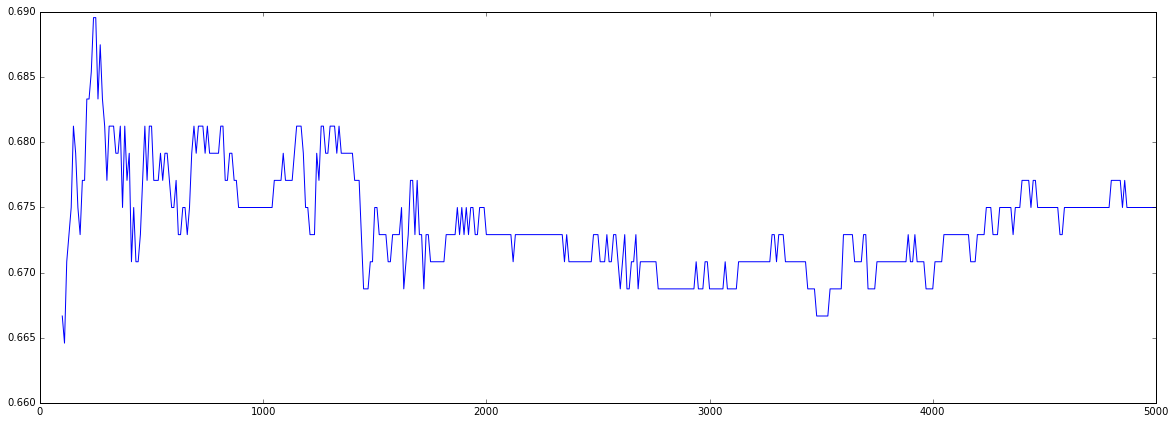

In [36]:
plt.figure(figsize=(20, 7))
plt.plot(est_nums, accuracy)

Нет, модель не переобучается. В виду того, что каждое отдельное дерево строится случайным образом, при увеличении числа деревьев модель уходит к некоторому предельному виду и качество уходит на асимптоту. 

Здесь вы можете поделиться мыслями о задании.

Задание понравилось тем, что показываец разницу в работе с методами.

А здесь — вставить нарисованную вами смешную картинку.

![Смешная(?) картинка](4.jpg)